## Image Segmentation

### Imports

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from scipy import ndimage as ndi
from skimage.feature import peak_local_max
from sklearn.cluster import MeanShift
from skimage.segmentation import watershed
# Required to calculate Dice Similarity Coefficient

from PIL import Image

# Reduce size of original image to reduce computation time
size = 100,100 # change here

#### Function for displaying images

In [5]:
def plot_two_images(figure_title, image1, label1, image2, label2, 
                    cmap1=None, cmap2=None):
    
    fig = plt.figure()
    fig.suptitle(figure_title)

    # Display the first image
    fig.add_subplot(1, 2, 1)
    plt.imshow(image1, cmap = cmap1)
    plt.axis('off')
    plt.title(label1)

    # Display the second image
    fig.add_subplot(1, 2, 2)
    plt.imshow(image2, cmap = cmap2)
    plt.axis('off')
    plt.title(label2)

    plt.show()

#### Function for applying MeanShift algorithm

In [6]:
def apply_meanshift(img):
    # Step 1 - Extract the three RGB colour channels
    im = np.array(img)
    red = im[:, :, 0]
    green = im[:, :, 1]
    blue = im[:, :, 2]
    
    # Step 2 - Store original image shape to be used later in resizing
    original_shape = red.shape
    # Combine the three colour channels by flattening each channel
    # Then stack the flattened channels together
    # This gives the "colour_samples"
    colour_samples = np.column_stack([red.flatten(), green.flatten(), blue.flatten()])
    
    # Step 3 - Perform MeanShift clustering
    # For larger images this may take a few minutes to compute
    ms_clf = MeanShift(bin_seeding=True)
    ms_labels = ms_clf.fit_predict(colour_samples)

    # Step 4 - Reshape ms_labels back to the original image shape
    # for displaying the segmentation output
    ms_labels = ms_labels.reshape(original_shape)  
    return ms_labels

#### Function for applying Watershed algorithm

In [34]:
def apply_watershed(img, threshold=None, plotDistTransform = False):
    
    # TODO: Apply Watershed to image
    # Consider the following hints as per the lab specification
    
    img_grey = img.convert('L')
    
    # Convert to binary image (note: can also use cv thresholding)
    if threshold is not None:
        img_grey = img_grey.point(lambda x: 0 if x > threshold else 255, '1')

    # Step 1 - Convert the image to grayscale and then binary
    # and convert the image to a numpy matrix      
    img_array = np.array(img_grey)

    
    # Step 2 - Calculate the distance transform
    # Hint: Use ndi.distance_transform_edt(img_array)
    distance = ndi.distance_transform_edt(img_array)

    # Remember to plot distance transform for Task 2
    
    # Step 3 - Generate the Watershed markers
    # Hint: Use the peak_local_max() function from the skimage.feature library
    # to get the local maximum values and then convert them to markers
    # Remember to change the local search region for good segmentation results
    # using ndi.label() (note the markers are the 0th output of this function)
    local_max = peak_local_max(distance, indices=False, footprint=np.ones((6, 6)), labels=img_array)

    markers = ndi.label(local_max)[0]
    
    # Step 4 - Perform Watershed and store the labels
    # Hint: Use the watershed() function from the skimage.morphology library
    # with three inputs: -distance, markers and your image array as a mask
    ws_labels = watershed(-distance, markers, mask=img_array)
    return ws_labels, distance

### Q1. Use the MeanShift algorithm for image segmentation

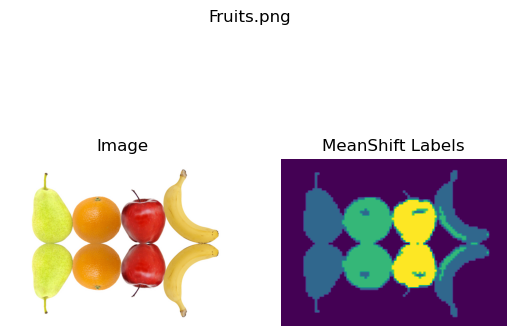

In [11]:
# Specify path to the test image
img_path = 'Fruits.png'

# Read image
img = Image.open(img_path)
img.thumbnail(size)

# Apply MeanShift algorithm to the image
ms_labels = apply_meanshift(img) # change here

# Read and plot the original image and MeanShift result
img = mpimg.imread(img_path)# change here

plot_two_images(img_path, img, "Image", ms_labels, "MeanShift Labels")

### Q2. Use Watershed transformation for image segmentation

/var/folders/qz/2dg5bw_50kdcwkdm7trt45300000gn/T/ipykernel_4023/877608287.py:28: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_max = peak_local_max(distance, indices=False, footprint=np.ones((6, 6)), labels=img_array)


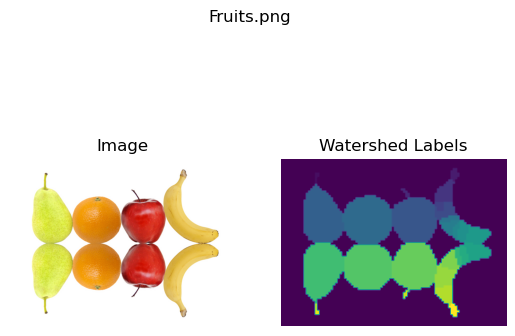

In [35]:
# Read image from img_path as specified above
img = Image.open(img_path)
img.thumbnail(size)

# Apply Watershed algorithm (remember to plot distance transform as well)
ws_labels, distance = apply_watershed(img, threshold=240) # Change here

# Read the original image
img = mpimg.imread(img_path) # change here

plot_two_images(img_path, img, "Image", ws_labels, "Watershed Labels")

### Q3. Compare MeanShift and Watershed segmentation results

In [40]:
# List of MaskX.png images
MaskX = ['Mask{}.png'.format(str(idx)) for idx in range(1,9)]

# Generate list of unique MeanShift labels and corresponding label image masks
lbl_ms_unique = np.unique(ms_labels)
ms_masks = np.unique(ms_labels, return_counts = True)[1]

# Generate list of unique Watershed labels and corresponding label image masks
# Hint: Make sure you have generated reasonable watershed segmentation results
lbl_ws_unique = np.unique(ws_labels)
ws_masks = np.unique(ws_labels, return_counts = True)[1]
sum_ms = 0
sum_ws = 0

# Iterate over MaskX.png images and calculate DSC
for each_maskx_image in MaskX:
    # Read each MaskX.png image
    im1 = Image.open(each_maskx_image)
    im1.thumbnail(size)

    # Check DSC for each MeanShift label
    im1 = np.array(im1)
    row, col = im1.shape
    ms_dsc = []
    intersection_ms = 0
    for i in range(row):
        for j in range(col):
            if im1[i][j] == 255 and ms_labels[i][j] != 0:
                ms_dsc.append(ms_labels[i][j])   
                intersection_ms += 1    
    count_ms = 0
    for i in set(ms_dsc):
        count_ms += ms_masks[list(lbl_ms_unique).index(i)]
    label_counts = np.count_nonzero(im1)
    DSC_MS = 2 * intersection_ms / (count_ms + label_counts)
    print(f'DSC for {each_maskx_image} meanshift label: {DSC_MS}')

    # Check DSC for each Watershed label
    ws_dsc = []
    intersection_ws = 0
    for i in range(row):
        for j in range(col):
            if im1[i][j] == 255 and ws_labels[i][j] != 0:
                intersection_ws += 1
                ws_dsc.append(ws_labels[i][j])
    count_ws = 0
    for i in set(ws_dsc):
        count_ws += ws_masks[list(lbl_ws_unique).index(i)]
    DSC_WS = 2 * intersection_ws / (count_ws + label_counts)
    print(f'DSC for {each_maskx_image} watershed label: {DSC_WS}')
   
    sum_ms += DSC_MS
    sum_ws += DSC_WS
    
print('DSC for Average meanshift label:', sum_ms/6)
print('DSC for Average watershed label:', sum_ws/6)

DSC for Mask1.png meanshift label: 0.34879624192601294
DSC for Mask1.png watershed label: 0.7805519053876478
DSC for Mask2.png meanshift label: 0.2576489533011272
DSC for Mask2.png watershed label: 0.7990012484394506
DSC for Mask3.png meanshift label: 0.18839137645107795
DSC for Mask3.png watershed label: 0.7877947295423023
DSC for Mask4.png meanshift label: 0.17724649629018963
DSC for Mask4.png watershed label: 0.6475903614457831
DSC for Mask5.png meanshift label: 0.3543859649122807
DSC for Mask5.png watershed label: 0.7779204107830552
DSC for Mask6.png meanshift label: 0.2547207713941342
DSC for Mask6.png watershed label: 0.80970625798212
DSC for Mask7.png meanshift label: 0.1845336873547959
DSC for Mask7.png watershed label: 0.7606019151846786
DSC for Mask8.png meanshift label: 0.1773927392739274
DSC for Mask8.png watershed label: 0.6564885496183206
DSC for Average meanshift label: 0.32385270515059095
DSC for Average watershed label: 1.0032758963972264


From the results, we can find that the performance of watershed algorithm is much better than the meanshift algorithm, and the DSC of each mask in the watershed is more than 0.85. The reason is that compared with the meanshift algorithm, the watershed algorithm has a good response to weak edges, which is the guarantee of generating closed continuous edges. The noise in the image and the subtle gray level change on the object surface may cause over segmentation. Therefore, Gaussian filtering can be used to avoid local minimum points in the image forming small regions by themselves